# Transfer Learning

Transfer learning is using the weights of another model that is learned from another problem for our own problem.

There are two main benefits to using transfer learning:

- Can leverage an existing neural network architecture proven to work on problems similar to our own.
- Can leverage a working neural network architecture which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.


## Feature Extraction

In [ ]:
# Check gpu availablity
!nividia-smi

/bin/bash: line 1: nividia-smi: command not found


### Exploring Dataset

In [ ]:
# # Get data (10% of 10 food classes from Foof101)
# import zipfile

# # Download the data
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# # Extract and save
# zipref = zipfile.ZipFile("10_food_classes_10_percent.zip")
# zipref.extractall("/content/drive/MyDrive/Colab Notebooks")
# zipref.close()

In [ ]:
# Walk through directories
import os

for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/Colab Notebooks/10_food_classes_10_percent"):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 0 images in /content/drive/MyDrive/Colab Notebooks/10_food_classes_10_percent
There are 10 directories and 0 images in /content/drive/MyDrive/Colab Notebooks/10_food_classes_10_percent/test
There are 0 directories and 250 images in /content/drive/MyDrive/Colab Notebooks/10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in /content/drive/MyDrive/Colab Notebooks/10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images in /content/drive/MyDrive/Colab Notebooks/10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in /content/drive/MyDrive/Colab Notebooks/10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in /content/drive/MyDrive/Colab Notebooks/10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in /content/drive/MyDrive/Colab Notebooks/10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images 

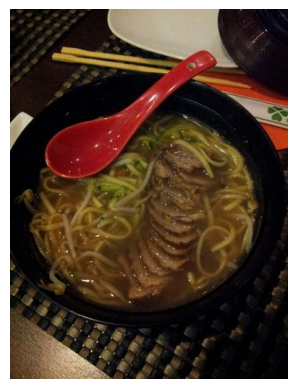

In [ ]:
# Show random images
dirpath = '/content/drive/MyDrive/Colab Notebooks/10_food_classes_10_percent/train/'
classname = 'ramen/'

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

files = os.listdir(dirpath + classname)
img = mpimg.imread(dirpath+classname+random.choice(files))

plt.imshow(img)
plt.axis('off')
plt.show();

### Data loader (preparing the data)

In [ ]:
# Load our images
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224, 224)
BATCH_SIZE = 64

train_dir = '/content/drive/MyDrive/Colab Notebooks/10_food_classes_all_data/train'
test_dir = '/content/drive/MyDrive/Colab Notebooks/10_food_classes_all_data/test'

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Training Images")
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=IMG_SHAPE,
                                               class_mode='categorical',
                                               batch_size=BATCH_SIZE)

print("Testing Images")
test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=IMG_SHAPE,
                                             class_mode='categorical',
                                             batch_size=BATCH_SIZE)


Training Images
Found 7500 images belonging to 10 classes.
Testing Images
Found 2500 images belonging to 10 classes.


### Setting up callbacks (things to run whilst our model train

In [ ]:
# Create a tensorboard callback
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + '/' + experiment_name + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f'Saving tensorboard log files to: {log_dir}')
    return tensorboard_callback

### Create model using TensorFlow Hub

We can access various pretrained models on: https://www.tensorflow.org/hub


In [ ]:
# Let's compare following two models
resnet_url = 'https://www.kaggle.com/models/tensorflow/resnet-50/frameworks/TensorFlow2/variations/feature-vector/versions/1'

efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's make a function to create models from url's
def create_model(model_url, num_classes=10):
    """
    Take a TensorFlow Hub url and create a Keras Sequential model
    """
    # Download the pretrained model and save it as a Keras layer
    feature_extraction_layer = hub.KerasLayer(model_url,
                                              trainable=False,
                                              name='feature_extraction_layer',
                                              input_shape=IMG_SHAPE+(3,))

    # Create our own model
    model = tf.keras.Sequential([
        feature_extraction_layer,
        layers.Dense(num_classes, activation='softmax', name='output_layer')
    ])

    return model

In [ ]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data.num_classes)

# Compile our model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23561152  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23581642 (89.96 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23561152 (89.88 MB)
_________________________________________________________________


In [ ]:
# Let's fit our model on train data
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name='tf_hub',
                                                                         experiment_name='resnet/')])

Saving tensorboard log files to: tf_hub/resnet50-20240319-195831
Epoch 1/5
118/118 [==============================] - 2703s 23s/step - loss: 0.9426 - accuracy: 0.7004 - val_loss: 0.4407 - val_accuracy: 0.8604
Epoch 2/5
118/118 [==============================] - 64s 544ms/step - loss: 0.4935 - accuracy: 0.8423 - val_loss: 0.3851 - val_accuracy: 0.8760
Epoch 3/5
118/118 [==============================] - 65s 550ms/step - loss: 0.4045 - accuracy: 0.8743 - val_loss: 0.3540 - val_accuracy: 0.8860
Epoch 4/5
118/118 [==============================] - 65s 548ms/step - loss: 0.3520 - accuracy: 0.8873 - val_loss: 0.3453 - val_accuracy: 0.8892
Epoch 5/5
118/118 [==============================] - 64s 545ms/step - loss: 0.3122 - accuracy: 0.9032 - val_loss: 0.3458 - val_accuracy: 0.8820


In [ ]:
# Plot our loss curves
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title("Loss")
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


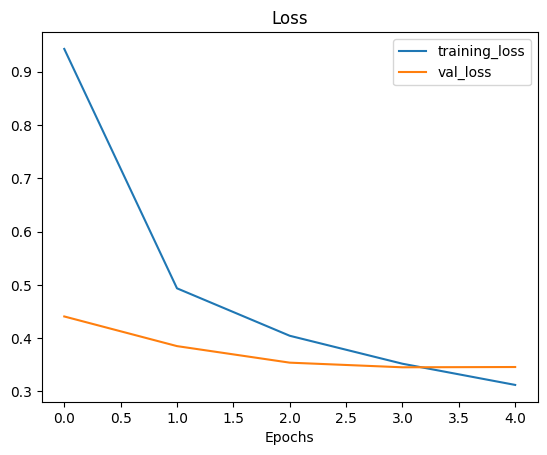

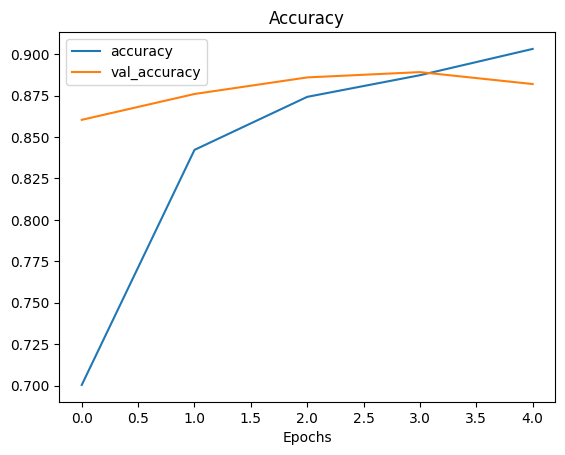

In [ ]:
# Loss curves for resnet
plot_loss_curves(resnet_history)

In [ ]:
# Create EfficientNet model
efficientnet_model = create_model(efficientnet_url,
                                  num_classes=train_data.num_classes)

# Compile EfficientNet Model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit our model to trining data
efficientnet_history = efficientnet_model.fit(train_data,
                                              epochs=5,
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name='tf_hub',
                                                                                     experiment_name='efficientnet/')])

Saving tensorboard log files to: tf_hub/efficientnet/20240319-204932
Epoch 1/5
118/118 [==============================] - 78s 558ms/step - loss: 0.9775 - accuracy: 0.7371 - val_loss: 0.4734 - val_accuracy: 0.8804
Epoch 2/5
118/118 [==============================] - 64s 538ms/step - loss: 0.5085 - accuracy: 0.8540 - val_loss: 0.3715 - val_accuracy: 0.8912
Epoch 3/5
118/118 [==============================] - 62s 524ms/step - loss: 0.4253 - accuracy: 0.8728 - val_loss: 0.3335 - val_accuracy: 0.9004
Epoch 4/5
118/118 [==============================] - 63s 531ms/step - loss: 0.3756 - accuracy: 0.8911 - val_loss: 0.3086 - val_accuracy: 0.9056
Epoch 5/5
118/118 [==============================] - 62s 522ms/step - loss: 0.3421 - accuracy: 0.8981 - val_loss: 0.2933 - val_accuracy: 0.9104


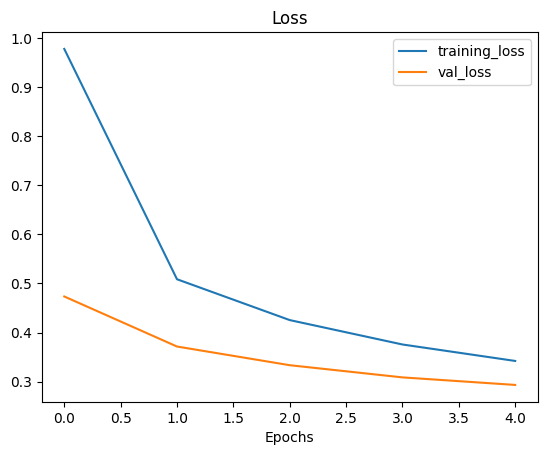

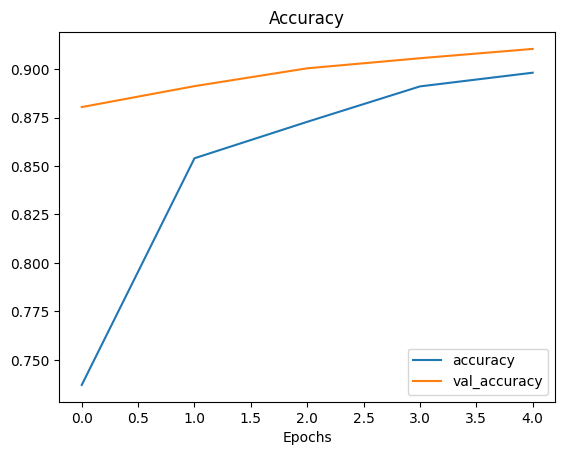

In [ ]:
# Loss curves for EfficientNet
plot_loss_curves(efficientnet_history)

## Fine Tuning

- Fine Tuning Transfer Learning Models
- Using Keras Functional API
- Use small dataset 10% to train faster
- Data Augumentation
- ModelCheckpoint callbacks

In [ ]:
import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices())

2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [ ]:
# Let's use 10% data of each class from our 10 food classes dataset
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

data_dir = '/content/drive/MyDrive/Colab Notebooks/10_food_classes_10_percent'

# Walk through our data dir
walk_through_dir(data_dir)

There are 2 directories and 0 images in '/content/drive/MyDrive/Colab Notebooks/10_food_classes_10_percent'.
There are 10 directories and 0 images in '/content/drive/MyDrive/Colab Notebooks/10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '/content/drive/MyDrive/Colab Notebooks/10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '/content/drive/MyDrive/Colab Notebooks/10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '/content/drive/MyDrive/Colab Notebooks/10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '/content/drive/MyDrive/Colab Notebooks/10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '/content/drive/MyDrive/Colab Notebooks/10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '/content/drive/MyDrive/Colab Notebooks/10_food_classes_10_percent/test/grilled_salmon'.
There are 0 dir

In [ ]:
# Create train and test dir paths
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'

In [ ]:
# Let's create tf.data.Dataset from image files in directory
IMG_SHAPE = (224, 224)
BATCH_SIZE = 64

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=IMG_SHAPE,
                                                                 label_mode='categorical',
                                                                 batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SHAPE,
                                                                label_mode='categorical',
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Check class name
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# Let's see batch of our data
for images, labels in train_data.take(1):
    print(images, labels)

tf.Tensor(
[[[[1.60357147e+02 4.74285736e+01 2.01989803e+01]
   [1.68688782e+02 5.43775520e+01 2.32397957e+01]
   [1.80275513e+02 6.10612259e+01 2.69234695e+01]
   ...
   [1.07750336e+02 5.31176491e+01 5.61239958e-01]
   [1.84551529e+02 1.23265762e+02 5.81943207e+01]
   [1.94115814e+02 1.25345390e+02 6.03453903e+01]]

  [[1.78239807e+02 6.13826523e+01 2.73316345e+01]
   [1.77775497e+02 5.96479607e+01 2.39285717e+01]
   [1.76974487e+02 5.69438782e+01 1.99438801e+01]
   ...
   [1.29725006e+02 7.38117371e+01 1.70972290e+01]
   [2.19913300e+02 1.55627533e+02 9.35561142e+01]
   [1.68881363e+02 9.41670761e+01 3.58813629e+01]]

  [[1.61377548e+02 5.04438782e+01 1.78010216e+01]
   [1.62673462e+02 5.18163261e+01 1.84591846e+01]
   [1.61265305e+02 5.36224480e+01 1.89744892e+01]
   ...
   [1.61128433e+02 9.84396591e+01 4.29394798e+01]
   [2.28183228e+02 1.57397461e+02 9.87852402e+01]
   [1.50234055e+02 6.90911331e+01 1.80810204e+01]]

  ...

  [[1.45714722e+01 7.21426392e+00 3.57147217e+00]
   [1

In [ ]:
# Create a transfer learning model using Functional API(more flexible)

# 1. Create base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=IMG_SHAPE+(3,), name='input_layer')

# 4. Add normalization layer
x = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255)(inputs)

# 5. Pass inputs to base model
x = base_model(inputs)
print(x.shape)

# 6. Average pool outputs of base model
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
print(x.shape)

# 7. Create output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine inputs and outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model
history_0 = model_0.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)))

(None, 7, 7, 1280)
(None, 1280)
Epoch 1/5
12/12 [==============================] - 401s 35s/step - loss: 2.0765 - accuracy: 0.2640 - val_loss: 1.6545 - val_accuracy: 0.5750
Epoch 2/5
12/12 [==============================] - 130s 11s/step - loss: 1.4351 - accuracy: 0.6720 - val_loss: 1.2235 - val_accuracy: 0.7312
Epoch 3/5
12/12 [==============================] - 150s 13s/step - loss: 1.0673 - accuracy: 0.7800 - val_loss: 0.8890 - val_accuracy: 0.8234
Epoch 4/5
12/12 [==============================] - 148s 13s/step - loss: 0.8586 - accuracy: 0.8107 - val_loss: 0.7750 - val_accuracy: 0.8250
Epoch 5/5
12/12 [==============================] - 163s 13s/step - loss: 0.7296 - accuracy: 0.8413 - val_loss: 0.6948 - val_accuracy: 0.8422


In [ ]:
model_0.save('base_model', save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
loaded_model = tf.keras.models.load_model('base_model')
loaded_model.evaluate(test_data)

40/40 [==============================] - 337s 8s/step - loss: 0.6895 - accuracy: 0.8428


[0.6894992589950562, 0.8428000211715698]

In [ ]:
model_0.evaluate(test_data)

40/40 [==============================] - 231s 6s/step - loss: 0.6895 - accuracy: 0.8428


[0.6894991397857666, 0.8428000211715698]

In [ ]:
# Check layers in our base model
for layer_no, layer in enumerate(base_model.layers):
    print(layer_no, layer.name)

0 input_4
1 rescaling_7
2 normalization_3
3 rescaling_8
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [ ]:
# Check summary of our base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_7 (Rescaling)     (None, None, None, 3)        0         ['input_4[0][0]']             
                                                                                                  
 normalization_3 (Normaliza  (None, None, None, 3)        7         ['rescaling_7[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_8 (Rescaling)     (None, None, None, 3)        0         ['normalization_3

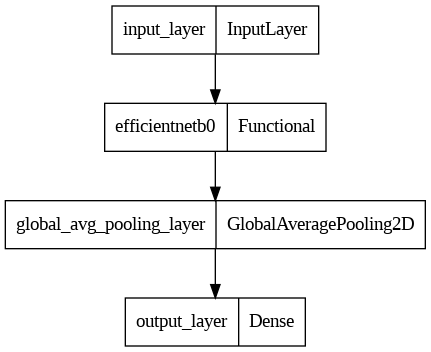

In [ ]:
# Plot our complete model
tf.keras.utils.plot_model(model_0)

In [ ]:
# Check our constructed model's summary
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pooling_layer (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


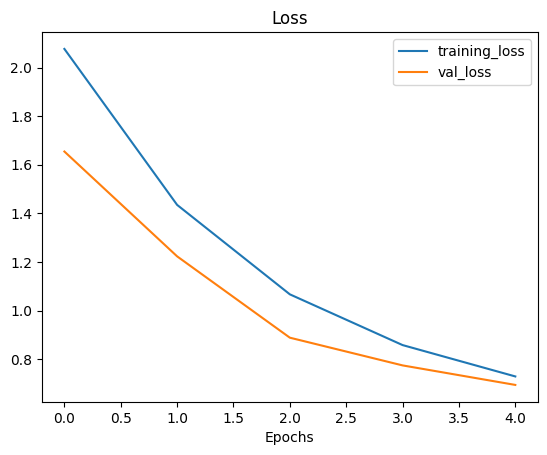

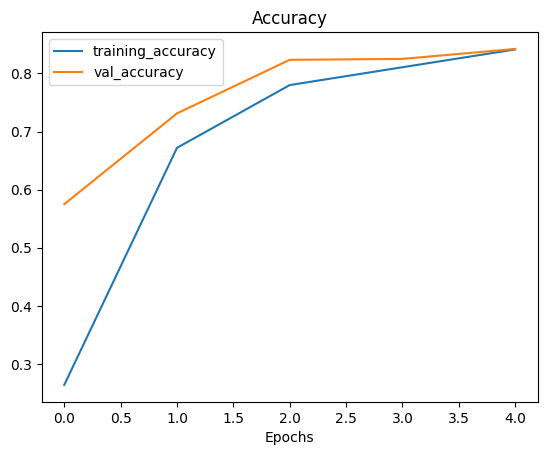

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

# Plot loss curves
plot_loss_curves(history_0)

### Experimentation

- **Model 1**: Use transfer learning on 1% of training data with data augumentation
- **Model 2**: Fine tune a transfer learning model on 100% of training data with data augumentation

In [ ]:
# Download 1% of training data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

import zipfile
zipref = zipfile.ZipFile('10_food_classes_1_percent.zip')
zipref.extractall()
zipref.close()

--2024-03-21 19:24:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.207, 172.217.193.207, 172.217.204.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   139MB/s    in 0.9s    

2024-03-21 19:24:51 (139 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



#### Model 1

In [ ]:
# Training and test data dir
train_dir = '10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/test'

In [ ]:
# Walk through our 1% data dir
import os

def walk_through_dir(dir_name):
    for dirpath, dirnames, filenames in os.walk(dir_name):
        print(f'There are {len(dirnames)} directories and {len(filenames)} files in "{dirpath}"')

walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 files in "10_food_classes_1_percent"
There are 10 directories and 0 files in "10_food_classes_1_percent/train"
There are 0 directories and 7 files in "10_food_classes_1_percent/train/sushi"
There are 0 directories and 7 files in "10_food_classes_1_percent/train/grilled_salmon"
There are 0 directories and 7 files in "10_food_classes_1_percent/train/chicken_curry"
There are 0 directories and 7 files in "10_food_classes_1_percent/train/chicken_wings"
There are 0 directories and 7 files in "10_food_classes_1_percent/train/ramen"
There are 0 directories and 7 files in "10_food_classes_1_percent/train/pizza"
There are 0 directories and 7 files in "10_food_classes_1_percent/train/hamburger"
There are 0 directories and 7 files in "10_food_classes_1_percent/train/fried_rice"
There are 0 directories and 7 files in "10_food_classes_1_percent/train/steak"
There are 0 directories and 7 files in "10_food_classes_1_percent/train/ice_cream"
There are 10 directories and 0 

In [ ]:
# Load train and test data
import tensorflow as tf

IMG_SHAPE = (224, 224)
BATCH_SIZE = 64

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=IMG_SHAPE,
                                                                 label_mode='categorical',
                                                                 batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SHAPE,
                                                                label_mode='categorical',
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Add data augumentation layer directly into the model

In [ ]:
# Data augumentation layer
import tensorflow as tf
from tensorflow.keras import layers

data_augumentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
], name='data_augumentation')



Text(0.5, 1.0, 'Image after augumentation')

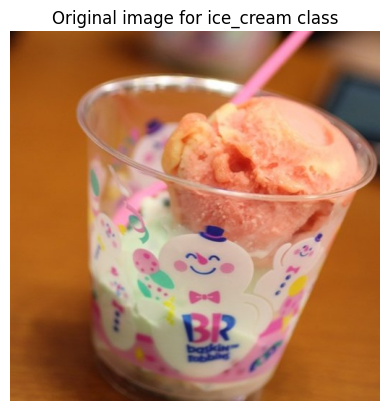

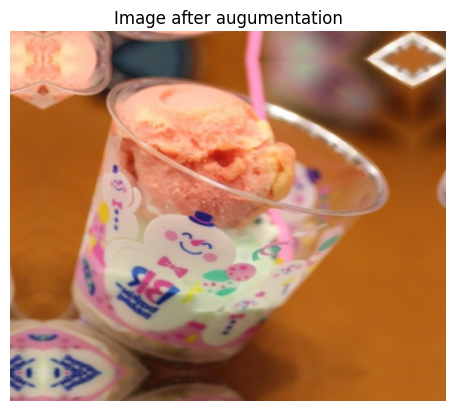

In [ ]:
# View random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data.class_names)
target_dir = train_dir + '/' + target_class

random_img = random.choice(os.listdir(target_dir))
random_img_path = target_dir + '/' + random_img

img = mpimg.imread(random_img_path)
plt.imshow(img)
plt.axis('off')
plt.title(f'Original image for {target_class} class')

# Augument the image
img_aug = data_augumentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(img_aug, axis=0)/255.)
plt.axis('off')
plt.title(f'Image after augumentation')

In [ ]:
# Create a model

## Setup input shape and base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

## Create input layer
inputs = layers.Input(shape=input_shape, name='input_layer')

## Add data augumentation layer
x = data_augumentation(inputs)

## Give input to base model
x = base_model(x, training=False)

## Pool features of base model
x = layers.GlobalAveragePooling2D(name='global_avg_pooling')(x)

## Dense layer as output
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

## Make a model
model_1 = tf.keras.Model(inputs=inputs, outputs=outputs)

## Compile  the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

## Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

24274472/24274472 [==============================] - 0s 0us/step
Epoch 1/5
2/2 [==============================] - 226s 205s/step - loss: 2.4856 - accuracy: 0.1000 - val_loss: 2.3406 - val_accuracy: 0.0960
Epoch 2/5
2/2 [==============================] - 208s 202s/step - loss: 2.2937 - accuracy: 0.1429 - val_loss: 2.2553 - val_accuracy: 0.1412
Epoch 3/5
2/2 [==============================] - 205s 202s/step - loss: 2.1417 - accuracy: 0.2429 - val_loss: 2.1824 - val_accuracy: 0.1868
Epoch 4/5
2/2 [==============================] - 208s 202s/step - loss: 2.0312 - accuracy: 0.3000 - val_loss: 2.1196 - val_accuracy: 0.2308
Epoch 5/5
2/2 [==============================] - 165s 161s/step - loss: 2.0019 - accuracy: 0.3429 - val_loss: 2.0607 - val_accuracy: 0.2820


In [ ]:
# Models summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augumentation (Sequen  (None, None, None, 3)     0         
 tial)                                                           
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_avg_pooling (Global  (None, 1280)              0         
 AveragePooling2D)                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                             

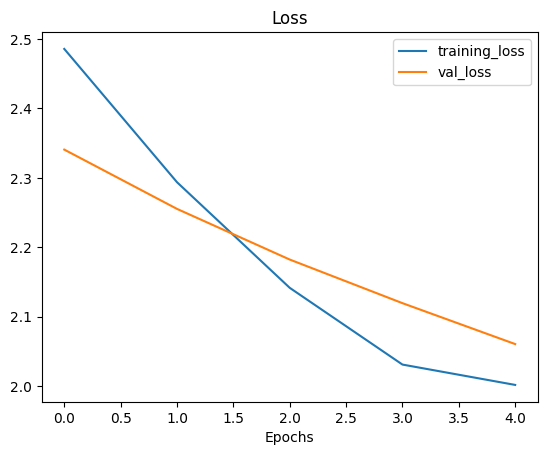

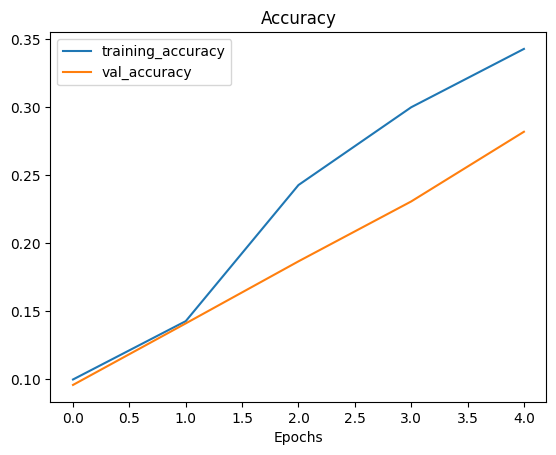

In [ ]:
# Plot loss curves

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(history_1)

#### Model 2

Fine Tunning model using 100% data of 10 food classes

In [1]:
# Setup data directories
train_dir = '/content/drive/MyDrive/Colab Notebooks/10_food_classes_all_data/train'
test_dir = '/content/drive/MyDrive/Colab Notebooks/10_food_classes_all_data/test'

In [2]:
# Check number of images in each class
import os

def walk_through_dir(dir_name):
    for dirpath, dirnames, filenames in os.walk(dir_name):
        print(f'There are {len(dirnames)} directories and {len(filenames)} files in "{dirpath}"')

walk_through_dir('/content/drive/MyDrive/Colab Notebooks/10_food_classes_all_data')

There are 2 directories and 0 files in "/content/drive/MyDrive/Colab Notebooks/10_food_classes_all_data"
There are 10 directories and 0 files in "/content/drive/MyDrive/Colab Notebooks/10_food_classes_all_data/test"
There are 0 directories and 250 files in "/content/drive/MyDrive/Colab Notebooks/10_food_classes_all_data/test/ice_cream"
There are 0 directories and 250 files in "/content/drive/MyDrive/Colab Notebooks/10_food_classes_all_data/test/chicken_curry"
There are 0 directories and 250 files in "/content/drive/MyDrive/Colab Notebooks/10_food_classes_all_data/test/steak"
There are 0 directories and 250 files in "/content/drive/MyDrive/Colab Notebooks/10_food_classes_all_data/test/sushi"
There are 0 directories and 250 files in "/content/drive/MyDrive/Colab Notebooks/10_food_classes_all_data/test/chicken_wings"
There are 0 directories and 250 files in "/content/drive/MyDrive/Colab Notebooks/10_food_classes_all_data/test/grilled_salmon"
There are 0 directories and 250 files in "/cont

In [3]:
# Setup data inputs
import tensorflow as tf

IMG_SHAPE = (224, 224)
BATCH_SIZE = 64

# This will make tf.Data.Datasets
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=IMG_SHAPE,
                                                                 label_mode='categorical',
                                                                 batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SHAPE,
                                                                label_mode='categorical',
                                                                batch_size=BATCH_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [4]:
for img, labels in train_data.take(1):
    print(img.shape, labels.shape)

(64, 224, 224, 3) (64, 10)


In [5]:
# Create a functional model with data augumentation
import tensorflow as tf
from tensorflow.keras import layers

data_augumentation = tf.keras.models.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.Rescaling(1./255)
], name='data_augumentation')

input_shape = (224, 224, 3)

# Create a base model and make last 10 layers trainable
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = True

for layer in base_model.layers[:-10]: # Freeze all layers except last 10 layers
    layer.trainable = False


24274472/24274472 [==============================] - 0s 0us/step


In [6]:
len(base_model.trainable_variables)

10

The ModelCheckpoint callback gives you the ability to save your model, as a whole in the SavedModel format or the weights (patterns) only to a specified directory as it trains.

This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains.

In [7]:
# Setup checkpoint path
checkpoint_path = 'model2/checkpoints.ckpt'

# Create a ModelCheckpoint callback that saves model's weight only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq='epoch',
                                                         verbose=1)

In [8]:
# Create Model 2's input and output layers
inputs = layers.Input(shape=input_shape, name='input_layer')
x = data_augumentation(inputs)
x = base_model(x, training=False) # keep base model into inferance mode, so batch norm layer's don't get updated
x = layers.GlobalAveragePooling2D(name='global_avg_pooling')(x)
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                metrics=['accuracy'])


In [9]:
# Fit the model and save checkpoints
initial_epochs = 5
history_model_2 = model_2.fit(train_data,
                              epochs=initial_epochs,
                              validation_data=test_data,
                              validation_steps=len(test_data),
                              callbacks=[checkpoint_callback])

Epoch 1/5
118/118 [==============================] - ETA: 0s - loss: 2.3230 - accuracy: 0.0963
Epoch 1: val_loss improved from inf to 2.31491, saving model to model2/checkpoints.ckpt
118/118 [==============================] - 1515s 13s/step - loss: 2.3230 - accuracy: 0.0963 - val_loss: 2.3149 - val_accuracy: 0.1000
Epoch 2/5
118/118 [==============================] - ETA: 0s - loss: 2.3163 - accuracy: 0.0984
Epoch 2: val_loss improved from 2.31491 to 2.30761, saving model to model2/checkpoints.ckpt
118/118 [==============================] - 130s 1s/step - loss: 2.3163 - accuracy: 0.0984 - val_loss: 2.3076 - val_accuracy: 0.1000
Epoch 3/5
118/118 [==============================] - ETA: 0s - loss: 2.3072 - accuracy: 0.0945
Epoch 3: val_loss improved from 2.30761 to 2.30287, saving model to model2/checkpoints.ckpt
118/118 [==============================] - 126s 1s/step - loss: 2.3072 - accuracy: 0.0945 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 4/5
118/118 [==========================

In [10]:
# Total trainable variables in our model
len(model_2.trainable_variables)

12

In [11]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augumentation (Sequen  (None, None, None, 3)     0         
 tial)                                                           
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_avg_pooling (Global  (None, 1280)              0         
 AveragePooling2D)                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                             

In [12]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(f'{layer_number} Layer Name: {layer.name} | Trainable: {layer.trainable}')

0 Layer Name: input_layer | Trainable: True
1 Layer Name: data_augumentation | Trainable: True
2 Layer Name: efficientnetv2-b0 | Trainable: True
3 Layer Name: global_avg_pooling | Trainable: True
4 Layer Name: output_layer | Trainable: True


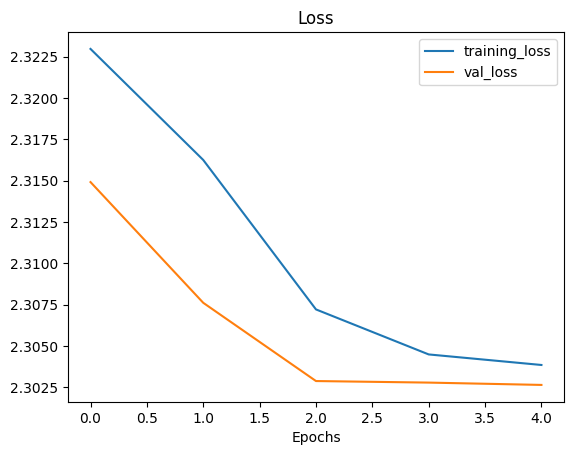

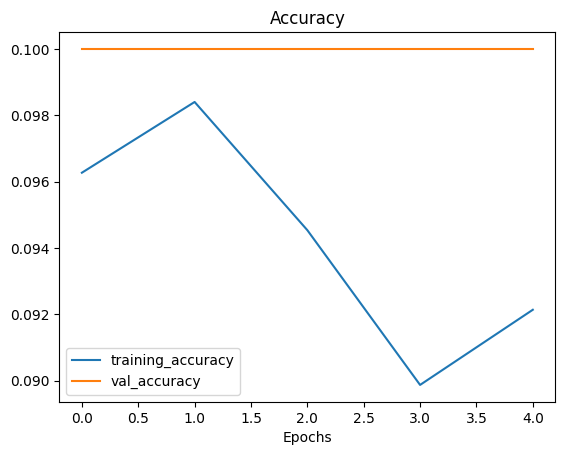

In [14]:
# Plot loss curves
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(history_model_2)

In [15]:
# Run for another 5 epochs
epochs = initial_epochs + 5

# Refit the model
history_model_2_fine = model_2.fit(train_data,
                                   epochs=epochs,
                                   validation_data=test_data,
                                   initial_epoch=history_model_2.epoch[-1],
                                   validation_steps=len(test_data),
                                   callbacks=checkpoint_callback)

Epoch 5/10
118/118 [==============================] - ETA: 0s - loss: 2.3032 - accuracy: 0.0967
Epoch 5: val_loss improved from 2.30264 to 2.30260, saving model to model2/checkpoints.ckpt
118/118 [==============================] - 98s 816ms/step - loss: 2.3032 - accuracy: 0.0967 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/10
118/118 [==============================] - ETA: 0s - loss: 2.3031 - accuracy: 0.0928
Epoch 6: val_loss improved from 2.30260 to 2.30259, saving model to model2/checkpoints.ckpt
118/118 [==============================] - 96s 800ms/step - loss: 2.3031 - accuracy: 0.0928 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/10
118/118 [==============================] - ETA: 0s - loss: 2.3030 - accuracy: 0.0956
Epoch 7: val_loss improved from 2.30259 to 2.30259, saving model to model2/checkpoints.ckpt
118/118 [==============================] - 85s 706ms/step - loss: 2.3030 - accuracy: 0.0956 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 8/10
118/118 [==============

In [16]:
def compare_historys(original_history, new_history):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]
    initial_epochs = len(acc)
    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.09626666456460953, 0.09839999675750732, 0.09453333169221878, 0.08986666798591614, 0.09213333576917648, 0.09666666388511658, 0.09279999881982803, 0.09560000151395798, 0.09173333644866943, 0.09546666592359543, 0.09960000216960907]


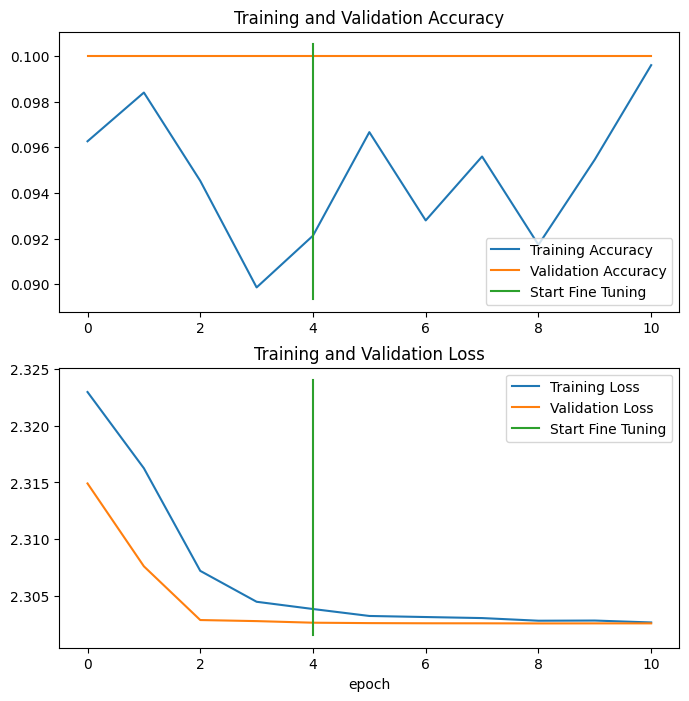

In [17]:
compare_historys(original_history=history_model_2,
                 new_history=history_model_2_fine)

In [18]:
# Evaluate our model
results = model_2.evaluate(test_data)
results

40/40 [==============================] - 10s 217ms/step - loss: 2.3026 - accuracy: 0.1000


[2.302581548690796, 0.10000000149011612]

In [19]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

40/40 [==============================] - 11s 228ms/step - loss: 2.3026 - accuracy: 0.1000


In [20]:
# Check if results of our native model and loaded models are same
import numpy as np
print(np.isclose(np.array(results), np.array(loaded_weights_model_results))) # Check if results are very close
print(results == loaded_weights_model_results)

[ True  True]
False
